# 함수, 클래스 형식으로 모듈화된 신경망을 구현하는 코드

In [21]:
import numpy as np
from collections import OrderedDict
 

#--------------------functions---------------------
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
 

def sigmoid_grad(x):
    return sigmoid(x) * (1.0 - sigmoid(x))
 

def mean_squared_error(y,t):
    return np.sum((y-t)**2)
 
#----------------------------------layers--------------------------------
 
class Relu:
    def __init__(self):
        self.mask = None
 
    def forward(self,x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
 
        return out
 
    def backward(self,dout):
        dout[self.mask] = 0
        dx = dout
 
        return dx
 

class Sigmoid:
    def __init__(self):
        self.out = None
 
    def forward(self,x):
        out = sigmoid(x)
        self.out = out
 
        return out
 
    def backward(self,dout):
        dx = dout * self.out * (1.0 - self.out)
 
        return dx
 

class Affine:
    def __init__(self,W,b):
        self.W = W
        self.b = b
 
        self.original_x_shape = None
        self.x = None
 
        self.dW = None
        self.db = None
 
    def forward(self,x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0],-1)
        self.x = x
 
        out = np.dot(self.x,self.W) + self.b
        return out
 
    def backward(self,dout):
        dx = np.dot(dout,self.W.T)
 
        self.dW = np.dot(self.x.T,dout)
        self.db = np.sum(dout, axis=0) #편향 공유 데이터끼리
 
        dx = dx.reshape(*self.original_x_shape)
        return dx


class MeanSquaredError:
    def __init__(self):
        self.y = None
        self.t = None
        self.loss = None
 
    def forward(self, x, t):
        self.y = x
        self.t = t
        self.loss = mean_squared_error(self.y, self.t) / self.y.shape[0]
        return self.loss
 
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

# 
# 은닉층이 1개인 신경망 구현

In [22]:
#---------------------------------- 신경망 구현 --------------------------
class Neural_Network:
    def __init__(self,input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
 
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Sigmoid'] = Sigmoid()
 
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.last_layer = MeanSquaredError()
 
    def predict(self,x):
        for layer in self.layers.values():
            x = layer.forward(x)
 
        return x
 
    def loss(self,x,t):
        y = self.predict(x)
 
        return self.last_layer.forward(y,t)
 
    def accuracy(self,x,t):
        y = self.predict(x)
        idx1 = np.where(y > 0.5)
        idx2 = np.where(y <= 0.5)
        y[idx1] = 1
        y[idx2] = 0
        
        acc = np.sum(y == t) / len(t)
        return acc
 
    def gradient(self,x,t):
        self.loss(x,t)
 
        dout = 1
        dout = self.last_layer.backward(dout)
 
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
 
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
 
        return grads

# 
# XOR 문제

In [23]:
X_data = np.array([[1, 1],
                  [1, 0],
                  [0, 1],
                  [0, 0]])
y_data = np.array([[0],
                  [1],
                  [1],
                  [0]])
print(X_data)
print(y_data)

[[1 1]
 [1 0]
 [0 1]
 [0 0]]
[[0]
 [1]
 [1]
 [0]]


# 
# 신경망 선언

In [24]:
network = Neural_Network(input_size=2,hidden_size=2,output_size=1)

learning_rate = 0.1
 
# 키 리스트 생성
key_list = []
for i in range(1,3):
    key_list.append('W' + str(i))
    key_list.append('b' + str(i))

print("초기화된 신경망의 파라미터값 :")
print(network.params)

초기화된 신경망의 파라미터값 :
{'W1': array([[ 0.38902179,  0.27673218],
       [-0.48973555,  0.89770404]]), 'b1': array([0., 0.]), 'W2': array([[ 0.30054648],
       [-1.88902985]]), 'b2': array([0.])}


# 
# 학습

In [25]:
import sys

In [26]:
for i in range(10000):
 
    grad = network.gradient(X_data,y_data)

    for key in key_list:
        network.params[key] -= learning_rate * grad[key]
 
    if i % 1000 == 0:
        print("=============================================================")
        print("\n{}th 업데이트".format(i))
        
        acc = network.accuracy(X_data, y_data)
        print("정확도 : ", acc)
        
        loss = network.loss(X_data, y_data)
        print("손실함수값 : ", loss)
        print("예측 : : \n", np.round(network.predict(X_data), 2))
        
        print("\n파라미터값 : \n", network.params)
        
        print("\n손실함수에 대한 각 파라미터의 미분값 : \n", grad)
        print("\n\n")


0th 업데이트
정확도 :  0.5
손실함수값 :  1.8811731195015906
예측 : : 
 [[-0.99]
 [-0.59]
 [-0.93]
 [-0.52]]

파라미터값 : 
 {'W1': array([[ 0.39488698,  0.24370449],
       [-0.48335531,  0.86498669]]), 'b1': array([ 0.01130083, -0.06404752]), 'W2': array([[ 0.37531572],
       [-1.78774606]]), 'b2': array([0.15544502])}

손실함수에 대한 각 파라미터의 미분값 : 
 {'W1': array([[-0.05865191,  0.33027687],
       [-0.06380242,  0.32717355]]), 'b1': array([-0.11300833,  0.64047522]), 'W2': array([[-0.74769238],
       [-1.01283785]]), 'b2': array([-1.55445024])}




1000th 업데이트
정확도 :  0.5
손실함수값 :  0.250147261291248
예측 : : 
 [[0.49]
 [0.51]
 [0.49]
 [0.51]]

파라미터값 : 
 {'W1': array([[ 0.36883879,  0.16350525],
       [-0.09100547,  0.03198524]]), 'b1': array([ 0.02877958, -0.35483258]), 'W2': array([[ 0.49910344],
       [-1.22495511]]), 'b2': array([0.76417316])}

손실함수에 대한 각 파라미터의 미분값 : 
 {'W1': array([[ 0.00013009,  0.00015925],
       [-0.00098023,  0.0008187 ]]), 'b1': array([2.63255368e-04, 7.47655732e-05]), 'W2': array

# 
# 경사하강법 스텝에 따른 손실함수 값 그래프

초기화된 신경망의 파라미터값 :
{'W1': array([[ 0.1520679 , -0.58214116],
       [-0.21409672, -0.27778393]]), 'b1': array([0., 0.]), 'W2': array([[-0.46148533],
       [-0.41024988]]), 'b2': array([0.])}


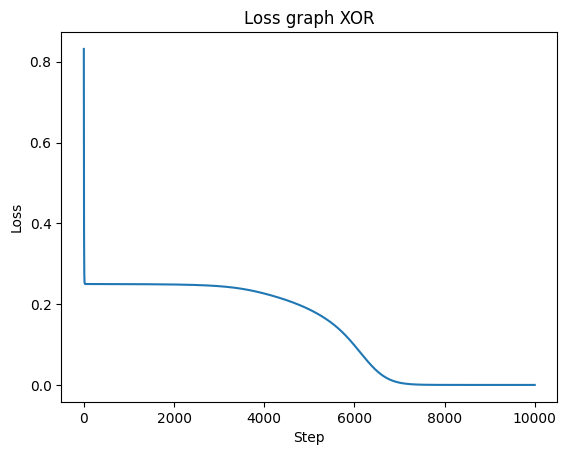

In [27]:
import matplotlib.pyplot as plt

network = Neural_Network(input_size=2,hidden_size=2,output_size=1)

learning_rate = 0.1
 
# 키 리스트 생성
key_list = []
for i in range(1,3):
    key_list.append('W' + str(i))
    key_list.append('b' + str(i))

print("초기화된 신경망의 파라미터값 :")
print(network.params)

loss_list = []
for i in range(10000):
 
    grad = network.gradient(X_data,y_data)

    for key in key_list:
        network.params[key] -= learning_rate * grad[key]
    
    loss_list.append(network.loss(X_data, y_data))
plt.plot(np.arange(len(loss_list)), loss_list)
plt.ylabel("Loss")
plt.xlabel("Step")
plt.title("Loss graph XOR")
plt.show()